In [ ]:
!pip install tensorflow



!pip install numpy==1.19.3

import numpy as np
import nibabel as nib
import glob
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tifffile import imsave
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler

print(np.__version__)

scaler = MinMaxScaler()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 15.7 MB 5.3 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.3
    Uninstalling numpy-1.19.3:
      Successfully uninstalled numpy-1.19.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached numpy-1.19.3-cp37-cp37m-manylinux2010_x86_64.whl (14.9 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray-einstats 0.2.2 requires numpy>=1.21, but you have numpy 1.19.3 which is incompatible.
tensorflow 2.8.0+zzzcolab20220506162203 requires numpy>=1.20, but you have numpy 1.19.3 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


1.21.6


In [ ]:
import os
#import numpy as np
import tensorflow
from tensorflow.keras.utils import to_categorical


def load_img(img_dir, img_list):

    images=[]
    ground_truth_list = []

    for i, image_name in enumerate(img_list):

        if (image_name.split('.')[1] == 'npz'):

            image_file_path = os.path.join(img_dir,image_name)

            MRI_image = np.load(image_file_path)

            image = np.transpose(MRI_image['a'],(1,2,0))

            images.append(image[56:184, 56:184])

            image_ground_truth = MRI_image['b'].astype(np.uint8)

            image_ground_truth = image_ground_truth[56:184, 56:184]

            n_classes = len(np.unique(image_ground_truth))

            n_classes = 5

            image_ground_truth = to_categorical(image_ground_truth, num_classes=n_classes)

            ground_truth_list.append(image_ground_truth)

            pass

        pass


    images = np.array(images)
    ground_truth_list = np.array(ground_truth_list)

    return(images,ground_truth_list)


In [ ]:
def imageLoader(img_dir, img_list, batch_size):

    L = len(img_list)

    #keras needs the generator infinite, so we will use while true
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)

            X , Y = load_img(img_dir, img_list[batch_start:limit])


            yield (X,Y) #a tuple with two numpy arrays with batch_size samples

            batch_start += batch_size
            batch_end += batch_size

In [ ]:
from google.colab import drive

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
print("Number of GPUs available : ", len(tf.config.list_physical_devices('GPU')))

tf.test.gpu_device_name()

Number of GPUs available :  0


''

-----
(128, 128, 5)

-----


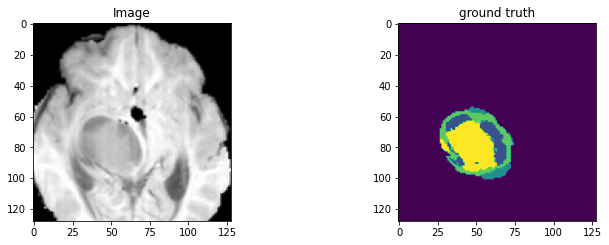

int64


In [ ]:
batch_size = 2
npz_files_folder_path = '/content/drive/MyDrive/'

file_name = 'brats_2013_pat0001_1slice76.npz'

file_2 = 'brats_2013_pat0001_1slice63.npz'

file_name_list = []

file_name_list.append(file_name)

file_name_list.append(file_2)


train_images_dataGenerator = imageLoader(img_dir=npz_files_folder_path,img_list=file_name_list,batch_size=batch_size)

X, Y = train_images_dataGenerator.__next__()

#npz_file = np.load(npz_file_path)

#mri_image_slice = np.transpose(npz_file['a'],(1,2,0))

#ground_truth = npz_file['b']




mri_image_slice = X[1]

ground_truth = Y[1]




print("-----")

#ground_truth = np.expand_dims(ground_truth, axis=2)

print(ground_truth.shape)


ground_truth=np.argmax(ground_truth, axis=2)

print()

print("-----")

plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(mri_image_slice[:,:,1], cmap='gray')
plt.title('Image')

plt.subplot(222)
plt.imshow(ground_truth[:,:])
plt.title('ground truth')

plt.show()

print(ground_truth.dtype)


In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K

In [ ]:
################################################################
def multi_unet_model(n_classes=5, IMG_HEIGHT=240, IMG_WIDTH=240, IMG_CHANNELS=4):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.2)(c1)  # Original 0.1
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2)  # Original 0.1
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)  # Original 0.1
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)  # Original 0.1
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    #model.summary()

    return model

In [4]:
!pip install segmentation-models
#!pip install segmentation-models-3D
import keras
import tensorflow
import os
import numpy as np


os.environ["SM_FRAMEWORK"] = "tf.keras"

###########################################################################
#Define loss, metrics and optimizer to be used for training
wt0, wt1, wt2, wt3 = 0.25,0.25,0.25,0.25
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3]))
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]

LR = 0.0001
optim = tensorflow.keras.optimizers.Adam(LR)
#######################################################################


#model = multi_unet_model()

#print(model.summary())

In [ ]:
batch_size = 1

npz_files_folder_path = '/content/drive/MyDrive/'

file_name = 'brats_2013_pat0001_1slice76.npz'
file_2 = 'brats_2013_pat0001_1slice63.npz'

file_name_list = []

file_name_list.append(file_name)
file_name_list.append(file_2)

train_images_dataGenerator = imageLoader(img_dir=npz_files_folder_path,img_list=file_name_list,batch_size=batch_size)

X, Y = train_images_dataGenerator.__next__()


steps_per_epoch = len(file_name_list)//batch_size
val_steps_per_epoch = len(file_name_list)//batch_size

print(steps_per_epoch)

model = multi_unet_model(n_classes=5,IMG_HEIGHT=128,IMG_WIDTH=128,IMG_CHANNELS=4)

#model.compile(optimizer = optim, loss=total_loss, metrics=metrics)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print(model.summary())

print(model.input_shape)
print(model.output_shape)

print("----------")
print(Y.shape)
print("----------")


2
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128, 128, 4  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_76 (Conv2D)             (None, 128, 128, 16  592         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_36 (Dropout)           (None, 128, 128, 16  0           ['conv2d_76[0][0]']              
                                )                                                         

In [ ]:
history=model.fit(train_images_dataGenerator,
          steps_per_epoch=steps_per_epoch,
          epochs=500,
          verbose=1,
          validation_data=(train_images_dataGenerator),
          validation_steps=val_steps_per_epoch,
          )

model.save('/content/drive/MyDrive/brats_3d.hdf5')

print(history)

Epoch 1/500
2/2 [==============================] - 3s 749ms/step - loss: 0.7060 - accuracy: 0.2102 - val_loss: 0.5593 - val_accuracy: 0.4673
Epoch 2/500
2/2 [==============================] - 1s 427ms/step - loss: 0.5062 - accuracy: 0.5791 - val_loss: 0.3661 - val_accuracy: 0.8012
Epoch 3/500
2/2 [==============================] - 1s 425ms/step - loss: 0.2945 - accuracy: 0.8213 - val_loss: 0.2648 - val_accuracy: 0.9201
Epoch 4/500
2/2 [==============================] - 1s 409ms/step - loss: 0.2695 - accuracy: 0.8766 - val_loss: 0.2356 - val_accuracy: 0.9248
Epoch 5/500
2/2 [==============================] - 1s 428ms/step - loss: 0.1450 - accuracy: 0.9482 - val_loss: 0.1788 - val_accuracy: 0.9263
Epoch 6/500
2/2 [==============================] - 1s 446ms/step - loss: 0.1893 - accuracy: 0.8972 - val_loss: 0.1868 - val_accuracy: 0.9264
Epoch 7/500
2/2 [==============================] - 1s 430ms/step - loss: 0.1003 - accuracy: 0.9522 - val_loss: 0.1010 - val_accuracy: 0.9264
Epoch 8/500
2

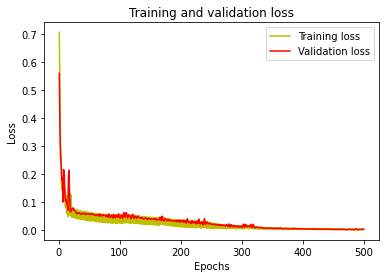

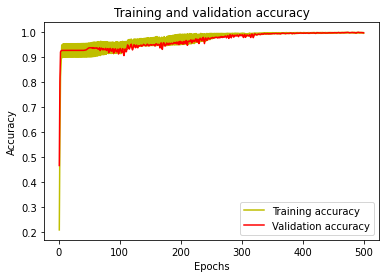

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


(128, 128, 4)
(1, 128, 128, 4)
(1, 128, 128, 5)
(128, 128)
-----
(128, 128, 5)


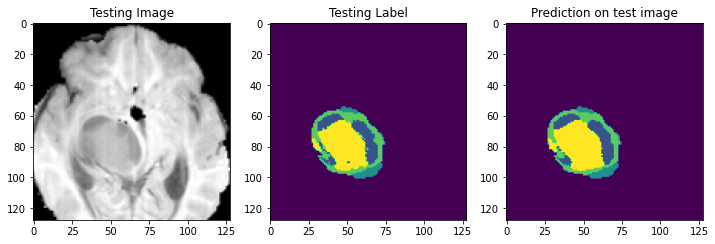

[0 1 2 3 4]


In [ ]:
#################################################
from keras.models import load_model

my_model = load_model('/content/drive/MyDrive/brats_3d.hdf5')

print(my_model)

print()

mri_image = X[1]

print(mri_image.shape)

test_img_input = np.expand_dims(mri_image, axis=0)

print(test_img_input.shape)

test_prediction = my_model.predict(test_img_input)

print(test_prediction.shape)

test_prediction_argmax=np.argmax(test_prediction, axis=3)[0,:,:]

print(test_prediction_argmax.shape)

prediction = test_prediction_argmax


ground_truth = Y[1]


print("-----")

#ground_truth = np.expand_dims(ground_truth, axis=2)

print(ground_truth.shape)


ground_truth=np.argmax(ground_truth, axis=2)

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(mri_image[:,:,1], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction[:,:])
plt.show()

print(np.unique(prediction))